In [1]:
import os

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

os.chdir(current_dir_path)

import time
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import seaborn as sns

from functions import *
from chi import *
from regressionP import *
from models import *

In [2]:
data1 = pd.read_csv("./Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("./Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("./Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("./Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("./Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("./Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6], ignore_index=True)

dataA1 = pd.read_csv("./Data/NPA_TMA1_new.csv")[:-2]

In [15]:
dataA2['道路障礙-視距品質名稱'].unique()

array(['無遮蔽物', '有遮蔽物'], dtype=object)

In [16]:
dataA2['道路障礙-視距名稱'].unique()

array(['良好', '路上停放車輛', '建築物', '彎道', '樹木、農作物', '坡道'], dtype=object)

In [3]:
def preprocess(input_data, select_lst):
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 7]
    dataA = sample_data[select_lst]
    
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df, sample_data

# List of columns to select
select_lst = [
    '路面狀況-路面狀態名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡', 
    '車輛撞擊部位大類別名稱-最初',
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者',
    '道路型態大類別名稱',
    '事故位置大類別名稱', 
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '事故位置子類別名稱', '事故類型及型態子類別名稱', 
    '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-個別',
    '當事者區分-類別-子類別名稱-車種',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', 
    '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃',
    '號誌-號誌動作名稱',
    '死亡受傷人數',
    '經度', '緯度',
]

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

rbind_data = pd.concat([dist_dfA1[0], dist_dfA2[0]], axis=0, ignore_index=True)

rbind_data.loc[rbind_data['受傷'] > 1, '受傷'] = 2
rbind_data['速限-第1當事者'] = rbind_data['速限-第1當事者'].apply(lambda x: 1 if x > 60 else 0)
rbind_data = process_age(rbind_data)

dist_df = process_data(rbind_data)
scaler = StandardScaler()

full_dist = pd.DataFrame(scaler.fit_transform(dist_df), columns = dist_df.columns)
X1 = full_dist.drop(['受傷', '死亡', '經度', '緯度'], axis=1)

print(full_dist.shape)
full_dist.head()

(190002, 32)


,路面狀況-路面狀態名稱,當事者屬-性-別名稱,當事者事故發生時年齡,車輛撞擊部位大類別名稱-最初,光線名稱,道路類別-第1當事者-名稱,速限-第1當事者,道路型態大類別名稱,事故位置大類別名稱,號誌-號誌種類名稱,...,行動電話或電腦或其他相類功能裝置名稱,當事者行動狀態大類別名稱,車輛撞擊部位大類別名稱-其他,肇因研判大類別名稱-個別,肇事逃逸類別名稱-是否肇逃,號誌-號誌動作名稱,經度,緯度,死亡,受傷
0,-0.355187,0.745712,-1.096234,-0.371880,0.111540,2.097702,-0.15,1.212144,0.484573,-0.709452,...,0.434569,0.143844,-0.317864,0.505131,-0.134457,0.832756,-0.603204,-1.816443,14.935241,-2.807915
1,-0.355187,0.745712,0.673842,1.177433,1.444841,-0.256845,-0.15,-0.813956,-0.873359,2.784275,...,0.434569,0.143844,-0.317864,0.505131,-0.134457,-1.199578,1.121705,0.994082,14.935241,-0.621437
2,-0.355187,0.745712,0.673842,-0.371880,-1.221761,2.882552,-0.15,1.212144,1.163539,-0.709452,...,-2.165591,-5.788560,-0.317864,0.505131,-0.134457,0.832756,-2.406538,-0.595579,14.935241,-2.807915
3,-0.355187,0.745712,-0.211196,-0.371880,-1.221761,-0.256845,-0.15,-0.813956,-0.873359,2.784275,...,0.434569,0.143844,-0.317864,0.505131,-0.134457,-1.199578,0.948751,1.035452,14.935241,-0.621437
4,-0.355187,0.745712,-1.096234,-0.371880,1.444841,2.097702,-0.15,1.212144,1.163539,-0.709452,...,-2.165591,0.143844,2.547982,0.505131,-0.134457,0.832756,1.833946,0.215091,14.935241,-2.807915


In [1]:
# for i in dist_dfA2[0].columns:
#     print(dist_dfA2[0][i].value_counts())

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
import time

select_lst_new = [
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者',
    '道路型態大類別名稱', 
    '事故位置大類別名稱',
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', 
    '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', 
    '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
]

start_time = time.time()

# Apply PCA
lens1 = PCA(10)
lens_result = lens1.fit_transform(X1[select_lst_new].to_numpy())

# Calculate Hamming distance
hamming_dist = pairwise_distances(lens_result, metric='hamming')

# Perform Agglomerative Clustering using precomputed distance matrix
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0.1, affinity='precomputed', linkage='average').fit(hamming_dist)
labels = clustering.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

n_clusters_

In [1]:
select_lst_new = [
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者',
    '道路型態大類別名稱', '事故位置大類別名稱',
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
]

start_time = time.time()

lens1 = PCA(10) # 10 最好
lens_result = lens1.fit_transform(X1[select_lst_new].to_numpy())

db = DBSCAN(eps=2.35, min_samples=10).fit(lens_result)
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

n_clusters_

In [19]:
rbind_data['label'] = labels

In [31]:
print(rbind_data[rbind_data['label'] == 0]['速限-第1當事者'].value_counts())
print(rbind_data[rbind_data['label'] == 1]['速限-第1當事者'].value_counts())
print(rbind_data[rbind_data['label'] == 2]['速限-第1當事者'].value_counts())

0    176937
Name: 速限-第1當事者, dtype: int64
0    8831
Name: 速限-第1當事者, dtype: int64
1    4090
Name: 速限-第1當事者, dtype: int64


In [32]:
print(rbind_data[rbind_data['label'] == 0]['事故類型及型態大類別名稱'].value_counts())
print(rbind_data[rbind_data['label'] == 1]['事故類型及型態大類別名稱'].value_counts())
print(rbind_data[rbind_data['label'] == 2]['事故類型及型態大類別名稱'].value_counts())

車與車      156667
車輛本身      20268
平交道事故         1
人與車           1
Name: 事故類型及型態大類別名稱, dtype: int64
人與車    8831
Name: 事故類型及型態大類別名稱, dtype: int64
車與車     3388
車輛本身     702
Name: 事故類型及型態大類別名稱, dtype: int64


In [126]:
for i in set(labels):
    noise_mask = labels == i
    noise_rows = rbind_data[noise_mask]

    print(i, ':', noise_rows.shape)

In [124]:
# noise_rows.to_csv('CalculatedData/離群比較/原始235_V2.csv', index=False) #2.35

## 比較不同的離群

In [20]:
lst_logit = [
    '路面狀況-路面狀態名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡', 
    '車輛撞擊部位大類別名稱-最初',
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者',
    '道路型態大類別名稱',
    '事故位置大類別名稱', 
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '事故位置子類別名稱', '事故類型及型態子類別名稱', 
    '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-個別',
    '當事者區分-類別-子類別名稱-車種',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', 
    '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃',
    '號誌-號誌動作名稱',
    '死亡'
]
data_origin = pd.read_csv('CalculatedData/離群比較/原始235_V2.csv')[lst_logit]
data_mapper = pd.read_csv('CalculatedData/離群比較/拓墣V2_new.csv')[lst_logit]

print(data_origin.shape)
print(data_mapper.shape)

(144, 29)
(391, 29)


In [21]:
overlapping_rows = pd.merge(data_origin, data_mapper)

# 使用所有列篩選，以确保完全匹配
overlapping_index_origin = data_origin[data_origin.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index
overlapping_index_mapper = data_mapper[data_mapper.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index

# 提取重叠的行
overlapping_rows_origin = data_origin.loc[overlapping_index_origin]
overlapping_rows_mapper = data_mapper.loc[overlapping_index_mapper]

non_overlapping_rows_origin = data_origin.loc[~data_origin.index.isin(overlapping_index_origin)].copy()
non_overlapping_rows_mapper = data_mapper.loc[~data_mapper.index.isin(overlapping_index_mapper)].copy()

print(non_overlapping_rows_origin.shape)
print(non_overlapping_rows_mapper.shape)
print('重複：', overlapping_rows.shape[0])

print(len(overlapping_index_origin) == len(overlapping_index_mapper))
print(overlapping_rows_origin.shape[0] == overlapping_rows_mapper.shape[0])

(56, 29)
(303, 29)
重複： 88
True
True


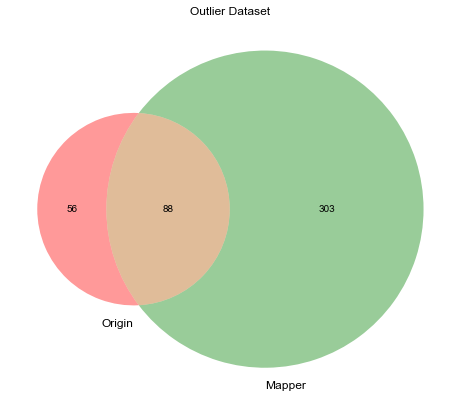

In [22]:
from matplotlib_venn import venn2 # 文氏圖

overlapping_rows_count = overlapping_rows.shape[0]
total_origin = non_overlapping_rows_origin.shape[0] + overlapping_rows_count
total_mapper = non_overlapping_rows_mapper.shape[0] + overlapping_rows_count

origin_set = set(range(total_origin))
mapper_set = set(range(total_mapper))

plt.figure(figsize=(8, 8))
venn = venn2(subsets = (non_overlapping_rows_origin.shape[0], non_overlapping_rows_mapper.shape[0], overlapping_rows_count), 
             set_labels = ('Origin', 'Mapper'))

plt.title('Outlier Dataset')
plt.show()

In [23]:
# full_out.head()

In [24]:
overlapping_rows = pd.merge(data_origin, data_mapper)
non_overlapping_rows_mapper = data_mapper.loc[~data_mapper.index.isin(overlapping_index_mapper)].copy()

overlapping_rows['type'] = 'overlap'
non_overlapping_rows_mapper['type'] = 'mapper'

data_combined = pd.concat([non_overlapping_rows_mapper, overlapping_rows], ignore_index=True)

full_dist = process_data(data_combined)
typedt = full_dist['type']

scaler = StandardScaler()
full_dist = pd.DataFrame(scaler.fit_transform(full_dist), columns = full_dist.columns)

full_dist.drop(['type'], axis=1, inplace=True)

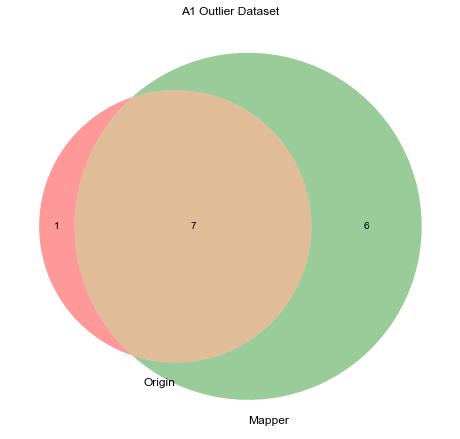

In [25]:
lst_logit = [
    '路面狀況-路面狀態名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡', 
    '車輛撞擊部位大類別名稱-最初',
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者',
    '道路型態大類別名稱',
    '事故位置大類別名稱', 
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '事故位置子類別名稱', '事故類型及型態子類別名稱', 
    '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-個別',
    '當事者區分-類別-子類別名稱-車種',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', 
    '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃',
    '號誌-號誌動作名稱',
    '死亡', '受傷'
]
data_origin = pd.read_csv('CalculatedData/離群比較/原始235_V2.csv')[lst_logit]
data_mapper = pd.read_csv('CalculatedData/離群比較/拓墣V2_new.csv')[lst_logit]

data_origin = data_origin[data_origin['死亡'] != 0]
data_mapper = data_mapper[data_mapper['死亡'] != 0]

overlapping_rows = pd.merge(data_origin, data_mapper)

overlapping_index_origin = data_origin[data_origin.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index
overlapping_index_mapper = data_mapper[data_mapper.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index

overlapping_rows_origin = data_origin.loc[overlapping_index_origin]
overlapping_rows_mapper = data_mapper.loc[overlapping_index_mapper]

non_overlapping_rows_origin = data_origin.loc[~data_origin.index.isin(overlapping_index_origin)].copy()
non_overlapping_rows_mapper = data_mapper.loc[~data_mapper.index.isin(overlapping_index_mapper)].copy()

overlapping_rows_count = overlapping_rows.shape[0]
total_origin = non_overlapping_rows_origin.shape[0] + overlapping_rows_count
total_mapper = non_overlapping_rows_mapper.shape[0] + overlapping_rows_count

plt.figure(figsize=(8, 8))
venn = venn2(subsets = (non_overlapping_rows_origin.shape[0], non_overlapping_rows_mapper.shape[0], overlapping_rows_count), 
             set_labels = ('Origin', 'Mapper'))

plt.title('A1 Outlier Dataset')
plt.show()

In [26]:
# non_overlapping_rows_origin

In [27]:
# non_overlapping_rows_mapper

In [28]:
# overlapping_rows

In [29]:
# for i in overlapping_rows.columns:
#     print('--------------------------',i,'--------------------------')
#     print('overlap \n', overlapping_rows[i].value_counts())
#     print('mapper \n', non_overlapping_rows_mapper[i].value_counts())

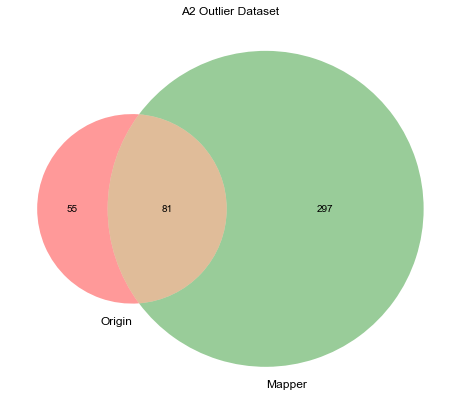

In [30]:
data_origin = pd.read_csv('CalculatedData/離群比較/原始235_V2.csv')[lst_logit]
data_mapper = pd.read_csv('CalculatedData/離群比較/拓墣V2_new.csv')[lst_logit]

data_origin = data_origin[data_origin['死亡'] == 0]
data_mapper = data_mapper[data_mapper['死亡'] == 0]

overlapping_rows = pd.merge(data_origin, data_mapper)

# 使用所有列篩選，以确保完全匹配
overlapping_index_origin = data_origin[data_origin.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index
overlapping_index_mapper = data_mapper[data_mapper.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index

# 提取重叠的行
overlapping_rows_origin = data_origin.loc[overlapping_index_origin]
overlapping_rows_mapper = data_mapper.loc[overlapping_index_mapper]

non_overlapping_rows_origin = data_origin.loc[~data_origin.index.isin(overlapping_index_origin)].copy()
non_overlapping_rows_mapper = data_mapper.loc[~data_mapper.index.isin(overlapping_index_mapper)].copy()

overlapping_rows_count = overlapping_rows.shape[0]
total_origin = non_overlapping_rows_origin.shape[0] + overlapping_rows_count
total_mapper = non_overlapping_rows_mapper.shape[0] + overlapping_rows_count

plt.figure(figsize=(8, 8))
venn = venn2(subsets = (non_overlapping_rows_origin.shape[0], non_overlapping_rows_mapper.shape[0], overlapping_rows_count), 
             set_labels = ('Origin', 'Mapper'))

plt.title('A2 Outlier Dataset')
plt.show()

In [31]:
non_overlapping_rows_mapper.shape
overlapping_rows.shape

(81, 30)

# 區分連接點和Mapper獨有

In [32]:
select_lst = [
    '路面狀況-路面狀態名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡', 
    '車輛撞擊部位大類別名稱-最初',
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者',
    '道路型態大類別名稱',
    '事故位置大類別名稱', 
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '事故位置子類別名稱', '事故類型及型態子類別名稱', 
    '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-個別',
    '當事者區分-類別-子類別名稱-車種',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', 
    '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃',
    '號誌-號誌動作名稱',
]

non_overlapping_rows_mapper['label'] = 1
overlapping_rows['label'] = 0

labeled_data = pd.concat([non_overlapping_rows_mapper, overlapping_rows])
labeled_data.reset_index(drop=True, inplace=True)

def get_clusterN_logit(cluster_data, lst):
    scaler = StandardScaler()
    
    c0_for_lm = process_data(cluster_data)
    c0_for_lm_X = pd.DataFrame(scaler.fit_transform(c0_for_lm), columns=c0_for_lm.columns).reset_index(drop=True, inplace=False)
    # label設定
    c0_for_lm_y = cluster_data.apply(lambda row: 1 if row['label'] != 0 else 2, axis=1)
    # c0_for_lm_y = cluster_data['label']
        
    c0_for_lm_X = c0_for_lm_X[lst]
    
    return c0_for_lm_X, c0_for_lm_y


X, y = get_clusterN_logit(labeled_data, select_lst)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y.replace(2, 0), test_size=0.2, random_state=42)

logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

print(result.summary())

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
accuracy = log_reg.score(X_test, y_test)

print(f"Accuracy: {accuracy:.2f}")

Optimization terminated successfully.
         Current function value: 0.425470
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  302
Model:                          Logit   Df Residuals:                      274
Method:                           MLE   Df Model:                           27
Date:                Sun, 29 Sep 2024   Pseudo R-squ.:                  0.1897
Time:                        12:41:49   Log-Likelihood:                -128.49
converged:                       True   LL-Null:                       -158.57
Covariance Type:            nonrobust   LLR p-value:                 0.0002520
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
路面狀況-路面狀態名稱                 0.0614      0.163      0.378      0.706      -0.257   

In [34]:
p_values = result.pvalues
significant_factors = p_values[p_values < 0.05]
significant_factors.sort_values()

事故類型及型態大類別名稱           4.404469e-14
車道劃分設施-分道設施-快慢車道間名稱    5.453909e-10
速限-第1當事者               2.070593e-08
道路類別-第1當事者-名稱          2.158117e-05
號誌-號誌種類名稱              8.772462e-04
號誌-號誌動作名稱              1.071397e-02
肇事逃逸類別名稱-是否肇逃          3.418421e-02
dtype: float64

In [41]:
# plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # Window
plt.rcParams['font.sans-serif']=['Arial Unicode Ms'] # Mac
plt.rcParams['axes.unicode_minus'] = False

def plot_bar_comparison(df1, df2, feature, x_label, title, save_path):
    plt.figure(figsize=(14, 6))
    
    df1_counts = df1[feature].value_counts(normalize=True).reset_index()
    df2_counts = df2[feature].value_counts(normalize=True).reset_index()
    
    df1_counts['Source'] = 'Link'
    df2_counts['Source'] = 'Outlier'

    combined_counts = pd.concat([df1_counts, df2_counts])
    combined_counts.columns = [feature, 'Frequency', 'Source']

    ax = sns.barplot(data=combined_counts, x=feature, y='Frequency', hue='Source')
    plt.title(f'{feature} 頻率')
    plt.xticks(rotation=10)

    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Only annotate if height > 0
            ax.annotate(f'{height:.2%}', 
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', 
                        fontsize=10, color='black', xytext=(0, 5),
                        textcoords='offset points')

    ax.set_xlabel(x_label)
    ax.set_title(title)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()

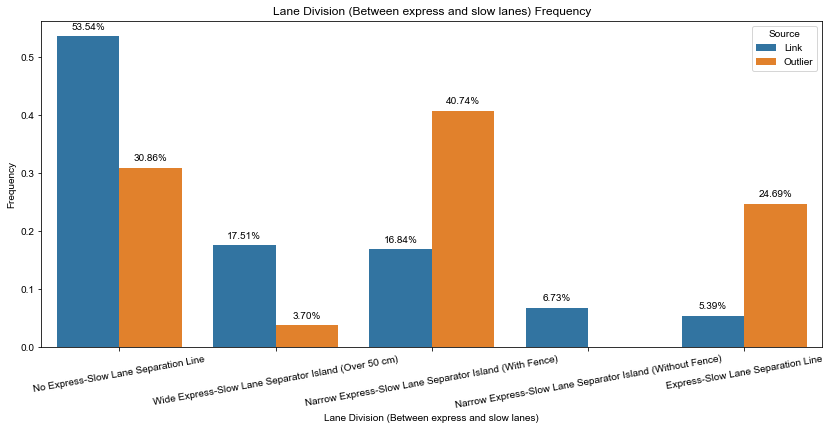

In [42]:
# 替換 '車道劃分設施-分道設施-快慢車道間名稱' 列中的值
non_overlapping_rows_mapper['車道劃分設施-分道設施-快慢車道間名稱'] = non_overlapping_rows_mapper['車道劃分設施-分道設施-快慢車道間名稱'].replace({
    '未繪設快慢車道分隔線': 'No Express-Slow Lane Separation Line',
    '快慢車道分隔線': 'Express-Slow Lane Separation Line',
    '寬式快慢車道分隔島(50公分以上)': 'Wide Express-Slow Lane Separator Island (Over 50 cm)',
    '窄式快慢車道分隔島(無柵欄)': 'Narrow Express-Slow Lane Separator Island (Without Fence)',
    '窄式快慢車道分隔島(附柵欄)': 'Narrow Express-Slow Lane Separator Island (With Fence)'
})
overlapping_rows['車道劃分設施-分道設施-快慢車道間名稱'] = overlapping_rows['車道劃分設施-分道設施-快慢車道間名稱'].replace({
    '未繪設快慢車道分隔線': 'No Express-Slow Lane Separation Line',
    '快慢車道分隔線': 'Express-Slow Lane Separation Line',
    '寬式快慢車道分隔島(50公分以上)': 'Wide Express-Slow Lane Separator Island (Over 50 cm)',
    '窄式快慢車道分隔島(無柵欄)': 'Narrow Express-Slow Lane Separator Island (Without Fence)',
    '窄式快慢車道分隔島(附柵欄)': 'Narrow Express-Slow Lane Separator Island (With Fence)'
})

x_label = 'Lane Division (Between express and slow lanes)'
title = 'Lane Division (Between express and slow lanes) Frequency'
plot_bar_comparison(non_overlapping_rows_mapper, overlapping_rows, '車道劃分設施-分道設施-快慢車道間名稱', x_label, title, save_path = 'CalculatedData/Plots/express_slow_frequency.png')